In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set path to google drive
path ="/content/drive/MyDrive/Colab Notebooks/Group_Project_2/AMZN_GOOG_MSFT_historical_data.csv"



In [6]:
# Read CSV file
data = pd.read_csv(path)

In [7]:
# To see data
data.head()

,Date,AMZN,MSFT,GOOGL
0,2016-01-04,636.73,54.790,759.41
1,2016-01-05,633.79,55.050,761.52
2,2016-01-06,632.81,54.075,759.30
3,2016-01-07,607.84,52.190,741.00
4,2016-01-08,607.23,52.330,730.92


In [8]:
# Prep. data frame
A_df=data.drop(columns=["GOOGL", "MSFT"])
A_df['Date'] = pd.to_datetime(A_df['Date'])
A_df.set_index('Date', inplace=True)
A_df.head()

,AMZN
Date,
2016-01-04,636.73
2016-01-05,633.79
2016-01-06,632.81
2016-01-07,607.84
2016-01-08,607.23


In [9]:
# Slicing the date range
a_df = A_df.loc['2020-03-02':'2021-05-03']
a_df.head()

,AMZN
Date,
2020-03-02,1954.00
2020-03-03,1908.88
2020-03-04,1976.46
2020-03-05,1924.03
2020-03-06,1901.14


In [10]:
# Rename the column name
df_1=a_df.rename(columns={"AMZN": "Close"})
df_1.head()

,Close
Date,
2020-03-02,1954.00
2020-03-03,1908.88
2020-03-04,1976.46
2020-03-05,1924.03
2020-03-06,1901.14


In [11]:
# Reset index
df = df_1.reset_index()
df.head()

,Date,Close
0,2020-03-02,1954.00
1,2020-03-03,1908.88
2,2020-03-04,1976.46
3,2020-03-05,1924.03
4,2020-03-06,1901.14


In [15]:
# Add exponential and rolling moving averages
df['EMA_5'] = df['Close'].ewm(5).mean().shift()
df['EMA_10'] = df['Close'].ewm(10).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()


In [16]:
# Set definition to calcluate RSI
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)


In [67]:
# Add MACD (Moving Average Convergence Divergence) to the dataframe
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())
df

,Date,Close,EMA_5,EMA_10,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2020-03-02,1954.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-03,1908.88,1954.000000,1954.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2,2020-03-04,1976.46,1929.389091,1930.365714,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
3,2020-03-05,1924.03,1948.010549,1947.215891,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
4,2020-03-06,1901.14,1940.291028,1940.566371,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
291,2021-04-27,3418.72,3342.561356,3295.506615,3350.74952,3364.01876,3346.335840,3221.813920,63.754337,62.313916,59.524737
292,2021-04-28,3461.12,3355.254464,3306.707832,3367.55752,3365.89076,3359.317840,3233.057253,65.250008,66.544962,60.928782
293,2021-04-29,3471.31,3372.898720,3320.745302,3387.47752,3378.56276,3371.433173,3245.347253,60.637139,69.914414,62.725908
294,2021-04-30,3470.02,3389.300600,3334.433002,3420.12600,3387.80476,3382.854507,3256.550920,59.843067,71.654646,64.511656


In [20]:
# Split stock data frame into three subsets: training ( 70% ), validation ( 15% ) and test ( 15% ) sets
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

test_df.head()

,Date,Close,EMA_5,EMA_10,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
252,2021-03-02,3095.990,3184.182072,3216.074966,3130.2598,3198.8969,3229.605267,3251.748967,31.750633,-37.093831,-13.823906
253,2021-03-03,3005.010,3169.483393,3205.158150,3110.3278,3181.7909,3214.438600,3251.463967,28.179536,-47.912675,-20.641660
254,2021-03-04,2977.040,3142.071161,3186.962864,3079.4238,3151.5119,3194.439267,3247.597633,28.047821,-58.074189,-28.128166
255,2021-03-05,3000.450,3114.565967,3167.878967,3063.3998,3116.2729,3173.802600,3238.007967,28.781702,-63.506211,-35.203775
256,2021-03-08,2951.951,3095.546640,3152.658152,3045.0200,3091.2179,3156.389267,3227.782633,27.235988,-70.907217,-42.344463


In [21]:
# Drop unnecessary columns

train_df = train_df.drop(columns=["Date"])
valid_df = valid_df.drop(columns=["Date"])
test_df  = test_df.drop(columns=["Date"])


In [22]:
# Set X_train, y_train, X_valid, y_valid, X_test, and y_test
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

X_train.head()

,EMA_5,EMA_10,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1954.000000,1954.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,1929.389091,1930.365714,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,1948.010549,1947.215891,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,1940.291028,1940.566371,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [23]:
# Set the parameters
parameters = {
# Number of boosted trees to fit
     'n_estimators': [1],  
# boosting learning rate
     'learning_rate': [0.001], 
# Maximum tree depth for base learners    
     'max_depth': [5],        
# Set random_state
    'random_state': [1]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]

model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False, parameters=parameters)
# objective='reg:squarederror' outputs regression with squared loss

In [25]:
# Fit the model
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1,
             eval_set=[(           EMA_5       EMA_10     SMA_5  ...        RSI       MACD  MACD_signal
0            NaN          NaN       NaN  ...        NaN        NaN          NaN
1    1954.000000  1954.000000       NaN  ...   0.000000        NaN          NaN
2    1929.389091  1930.365714       NaN  ...   0.000000        NaN          NaN
3    1948.010549  1947.215891       NaN  ...   0.000000        NaN          NaN
4    1940.291028  1940.566371       NaN  ...   0.000000        NaN          NaN
..           ......
             gamma=0, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None,
             objective='reg:squarederror',
             parameters={'learning_rate': [0.001], 'max_depth': [5],
                         'n_estimators': [1],

In [27]:
# Run predict
y_pred = model.predict(X_test)

In [30]:
# Define model evaluation method
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
cv = RepeatedKFold(n_splits=7, n_repeats=3, random_state=1)
# evaluate model to calculate mean absolute error
scores = cross_val_score(model, X_test, y_pred, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
# Calculate R2 (mean_square_error) to evaluate predictions
print(f'Mean_squared_error = {mean_squared_error(y_test, y_pred)}')

Mean MAE: 25.246 (14.367)
Mean_squared_error = 4574.592703999999


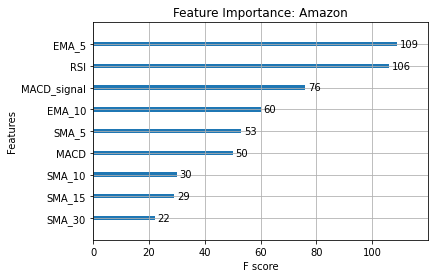

In [62]:
# Plot feature importance
plot_importance(model, title ='Feature Importance: Amazon');

In [57]:
# Prep to create a dataframe for the predicted value and actual closing price
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred
predicted_prices.Date
date_pred=pd.DataFrame(predicted_prices.Date)
date_pred=date_pred.reset_index(drop=True)
# Make the predicted value to DataFrame
amazon_pred = pd.DataFrame(y_pred)
# Make X_test value to DataFrame
actual=pd.DataFrame(y_test) 
actual_f=actual.reset_index(drop=True)
actual_f
# Combine date, closing price and predict value
actual_pred = pd.concat([date_pred, actual_f, amazon_pred], axis=1)

# Set the column name for the Predicted value
actual_pred.rename( columns={0 :'Pred'}, inplace=True )
# Calculate the difference and squar of diff.
actual_pred['Diff'] = actual_pred['Close'] - actual_pred['Pred']
actual_pred['Square'] = actual_pred['Diff']**2
actual_pred.head()

,Date,Close,Pred,Diff,Square
0,2021-03-02,3095.990,3035.244141,60.745859,3690.059431
1,2021-03-03,3005.010,3013.683105,-8.673105,75.222758
2,2021-03-04,2977.040,2990.897949,-13.857949,192.042757
3,2021-03-05,3000.450,3007.746826,-7.296826,53.243672
4,2021-03-08,2951.951,2989.209229,-37.258229,1388.175592


In [58]:
# calculate the total of diffeences
column_sum = actual_pred['Diff'].sum()
print(f"Total differences {column_sum}")
# calculate the mean squared error
MSE = actual_pred['Square'].mean()
print(f"Mean Squared Error {MSE}")
# Compute the root-mean-square
rms = np.sqrt(MSE)
print(f"Root Mean Square {rms}")
# calculate the mean of the closing prices
ClosingPrice = actual_pred['Close'].mean()
print(f"Mean Closing Price {ClosingPrice}")

Total differences -543.754368750002
Mean Squared Error 4574.592703999999
Root Mean Square 67.63573540666205
Mean Closing Price 3209.557695454545


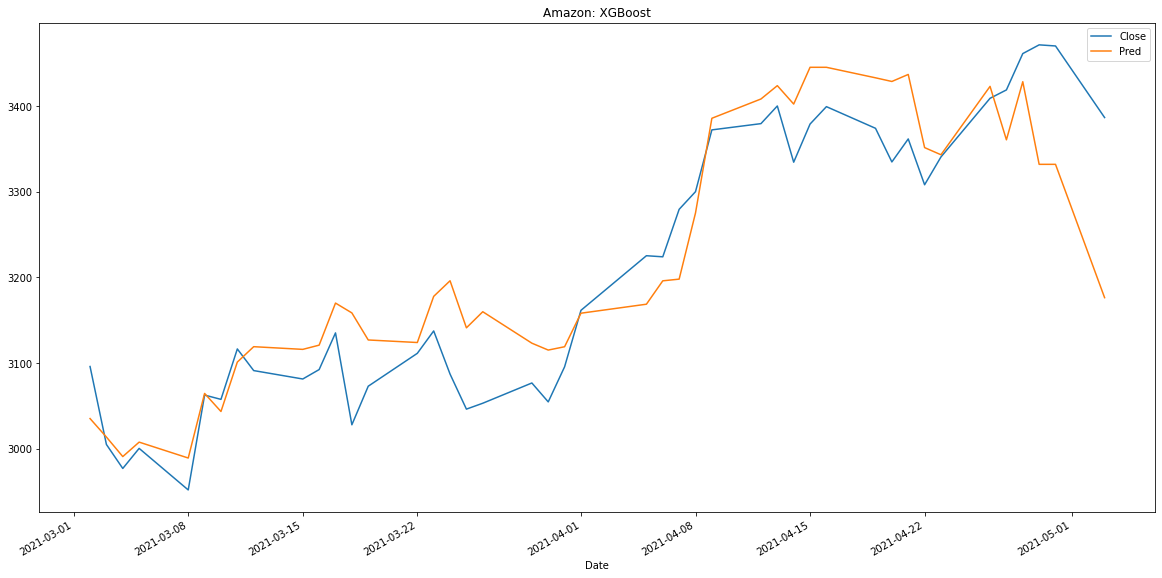

In [59]:
# Plot the closing price and predicted price
actual_pred.plot.line(x="Date", y=["Close", "Pred"], title="Amazon: XGBoost", figsize=(20,10));

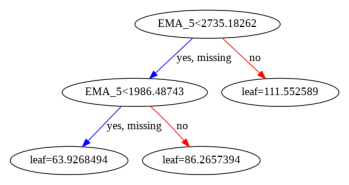

In [66]:
# Plot tree
plot_tree(model, num_trees=10);